In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import os
os.chdir("..")
os.chdir("Preprocessing")
from preprocessing import *
import selfies as sf

#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")
encoded_df = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\encoded_amino.csv")


In [3]:
data = df.copy()

In [2]:
data = df.copy()
# Kcat
data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros

# Assuming encoded_df is your one-hot encoded data from before
amino_pca = PCA(n_components=433)
principal_components = amino_pca.fit_transform(encoded_df)

# Convert to DataFrame
amino_pca_df = pd.DataFrame(data=principal_components)

In [4]:
from xgboost import XGBRegressor

data["Kcat"] = np.log10(data["Kcat"])

x = encoded_df
y = data["Kcat"]

x_train, x_test, y_train , y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [7]:
print(y)

0      -1.387216
1       0.008600
2      -1.080922
3      -1.425969
4      -0.420216
          ...   
4131    1.113943
4132    1.571709
4133    1.992554
4134    2.912063
4135    3.096910
Name: Kcat, Length: 4136, dtype: float64


In [5]:
# lets initialize the model
model = XGBRegressor()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)

print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 
print('r2:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mse))

MAE:  0.6684226945231213
MSE:  0.9525804239420307
r2: 0.6417731372331175
RMSE: 0.9760022663611139


In [12]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}


[0]	validation_0-rmse:1.44254	validation_1-rmse:1.54487
[1]	validation_0-rmse:1.29519	validation_1-rmse:1.40424


c:\Users\Gilbert\anaconda3\envs\bcb\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:1.21055	validation_1-rmse:1.33990
[3]	validation_0-rmse:1.11417	validation_1-rmse:1.26514
[4]	validation_0-rmse:1.03385	validation_1-rmse:1.19276
[5]	validation_0-rmse:0.98264	validation_1-rmse:1.16075
[6]	validation_0-rmse:0.94252	validation_1-rmse:1.13022
[7]	validation_0-rmse:0.90011	validation_1-rmse:1.10397
[8]	validation_0-rmse:0.84319	validation_1-rmse:1.07022
[9]	validation_0-rmse:0.80560	validation_1-rmse:1.04436
[10]	validation_0-rmse:0.77012	validation_1-rmse:1.02624
[11]	validation_0-rmse:0.73164	validation_1-rmse:1.01162
[12]	validation_0-rmse:0.70618	validation_1-rmse:0.99994
[13]	validation_0-rmse:0.69792	validation_1-rmse:1.00061
[14]	validation_0-rmse:0.68322	validation_1-rmse:0.99463
[15]	validation_0-rmse:0.67003	validation_1-rmse:0.99025
[16]	validation_0-rmse:0.66029	validation_1-rmse:0.98535
[17]	validation_0-rmse:0.65124	validation_1-rmse:0.98571
[18]	validation_0-rmse:0.64532	validation_1-rmse:0.98183
[19]	validation_0-rmse:0.64106	validati

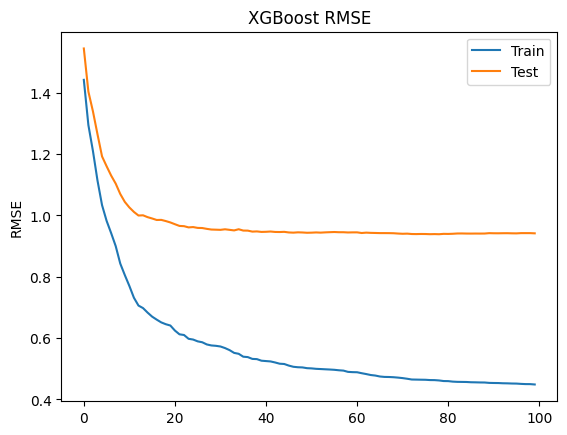

In [11]:
# print out the predictions

eval_set = [(x_train, y_train), (x_test, y_test)]
model.fit(x_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

# Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()